# Task 4. Multidimensional Data Visualization

I have chosen to implement ISOMAP method and test it on Swiss Roll and S Curve datasets:

In [14]:
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt

import numpy as np

from tqdm.auto import tqdm

import networkx as nx

from torch import randn, Tensor
from torch.nn.functional import pdist
from torch.nn.parameter import Parameter
from torch.nn.init import normal_
from torch.linalg import norm
from torch.optim import SGD

In [31]:
class ISOMAP:
    def __init__(self):
        pass
    
    def fit(self, X, k=5):
        self.N = X.shape[0]

        G = self.__create_graph(X, k)
        d = self.__create_dist_list(G)

        Y = Parameter(randn(self.N, 2))
        Y_final = self.__gradient_descend(Y, d)
        Y_np = Y_final.numpy()

        return Y_np


    def __create_graph(self, X, k):
        """
        Create a graph of nearest neighbors from dataset
        """
        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
        distances, indices = nbrs.kneighbors(X)
        distances, indices = distances[:, 1:], indices[:, 1:]

        G = nx.Graph()
        for u, (v_arr, dist_arr) in enumerate(zip(indices, distances)):
            for v, dist in zip(v_arr, dist_arr):
                G.add_edge(u, v, weight=dist)
        
        return G

    def __create_dist_list(self, G):
        """
        Create tensor-list with all shortest distances and walk through the elements of upper triangular matrix
        """
        shortest_distances = dict(nx.all_pairs_dijkstra_path_length(G))
        d = []
        for u in range(self.N - 1):
            for v in range(u + 1, self.N):
                d.append(shortest_distances[u][v])

        return Tensor(d)

    def __gradient_descend(self, Y, d, max_steps=500, eps=0.01, lr=1):
        """
        Perform gradient descend
        """
        optim = SGD([Y], lr = lr)
        prev_loss = Tensor([1e6])

        for i in tqdm(range(max_steps)):
            optim.zero_grad()
            Y_dist = pdist(Y, p=2)
            loss = ((d - Y_dist) **2).sum().sqrt()
            if prev_loss - loss.detach() < eps:
                break
            prev_loss = loss.detach()
            loss.backward()
            optim.step()
        return Y.detach()

    def plot(self, X, Y, color):
        fig = plt.figure(figsize=(10, 10))

        ax = fig.add_subplot(211, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)

        ax.set_title("Original data")
        ax = fig.add_subplot(212)
        ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.axis('tight')
        plt.title('Projected data')
        plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

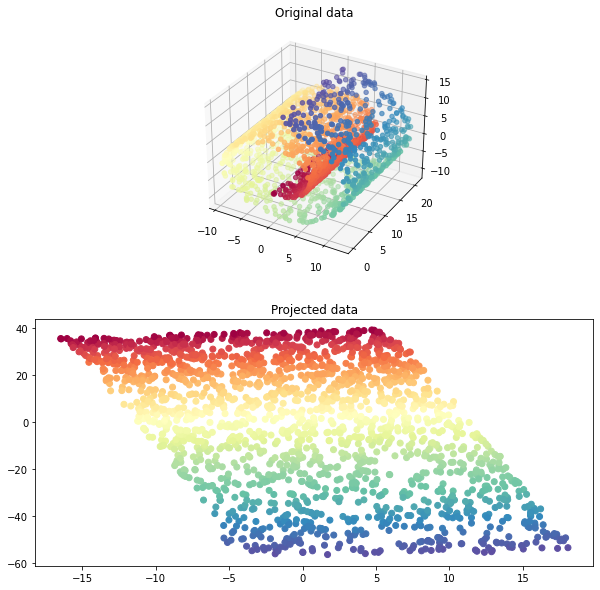

In [32]:
X, c = datasets.make_swiss_roll(n_samples=2000)

isomap = ISOMAP()
Y = isomap.fit(X, k=7)
isomap.plot(X, Y, color=c)

  0%|          | 0/500 [00:00<?, ?it/s]

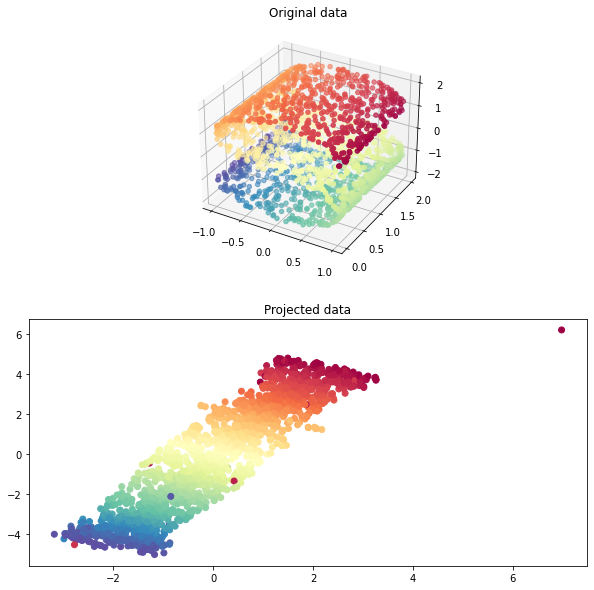

In [33]:
X, c = datasets.make_s_curve(n_samples=2000)

isomap = ISOMAP()
Y = isomap.fit(X, k=7)
isomap.plot(X, Y, color=c)